In [14]:
# Install necessary packages
#!pip install torchcam

In [15]:
# import necessary libraries
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm
import numpy as np
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.transforms import Lambda
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM, GradCAMpp, SmoothGradCAMpp, ScoreCAM, SSCAM, XGradCAM, LayerCAM

In [16]:
class UltrasoundDataset(Dataset):
    '''
    Custom dataset class for ultrasound images

    Args:
    dataframe: pandas dataframe containing image paths and labels
    transform: torchvision.transforms.Compose object for image augmentation for training/testing
    transform_og: torchvision.transforms.Compose object for image augmentation for visualizing original images
    return_og: bool, if True, returns original image along with transformed image

    Returns:
    image1: transformed image
    label: label of the image
    image2: original image (if return_og is True)
    '''
    def __init__(self, dataframe, transform=None, transform_og=None, return_og=False, return_img_name=False):   
        self.dataframe = dataframe
        self.transform = transform
        self.transform_og = transform_og
        self.return_og = return_og
        self.return_img_name = return_img_name

        if self.return_og:
            assert self.transform_og is not None, 'transform_og must be provided if return_og is True'

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join('..',self.dataframe.iloc[idx, 0])
        img_name = img_name.replace('\\', '/')
        label = self.dataframe.iloc[idx, 1]

        image = Image.open(img_name)
        if image.mode == 'RGBA':
            image = image.convert('RGB')

        if self.transform :
            image1 = self.transform(image)
        
        # if self.return_og:  
        #     image2 = self.transform_og(image)
        #     return image1,label, image2
        # else:
        #     return image1, label
        if self.return_og:
           image2 = self.transform_og(image)
           if self.return_img_name:
               return image1, label, image2, img_name
           else:
               return image1, label, image2
        else:
           if self.return_img_name:
               return image1, label, img_name
           else:
               return image1, label

        

In [17]:
class FocalLoss(torch.nn.Module):
    '''
    Focal loss function for imbalanced datasets with multiple classes
    '''
    def __init__(self, alpha=1, gamma=2, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, predictions, targets):
        if not self.logits:
            predictions = torch.nn.functional.softmax(predictions, dim=-1)

        CE_loss = torch.nn.functional.cross_entropy(predictions, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [18]:
class ClassificationTrainer:
    def __init__(self, model,epochs, criterion, optimizer,
                 train_dataloader,val_dataloader,model_save_dir,save_best_del_rest=True,use_scheduler=False, displ_print=True, pbar_visible=False):
        # attributes
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_dataloader = train_dataloader
        self.epochs = epochs
        self.val_data_loader = val_dataloader
        self.model_save_dir = model_save_dir
        self.save_best_del_rest = save_best_del_rest      # model saved after each epoch and deleted if not the best
        self.use_scheduler = use_scheduler
        self.displ_print = displ_print
        self.pbar_visible = pbar_visible


        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if use_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        # send model to device
        self.model.to(self.device)

        # check if model directory exits, otherwise create one
        if not os.path.exists(self.model_save_dir):
            os.makedirs(self.model_save_dir)

        if self.save_best_del_rest:
            self.metrics = {'train_loss':{}, 'train_acc':{}, 'val_loss':{}, 'val_acc':{}}

    def train(self):
        # put model in train mode
        self.model.train()

        with tqdm(range(self.epochs),disable=not self.pbar_visible) as pbar:
            for epoch in pbar:
                # running sum of loss and accuracy
                loss_list = []
                acc_list = []
                for i, (img, label) in enumerate(self.train_dataloader):
                    # set gradient to zero
                    self.optimizer.zero_grad()

                    # send to device
                    img = img.to(self.device)       # [batch_size, 3, 256, 256]
                    label = label.to(self.device)   # [batch_size,]

                    # forward pass
                    output = self.model(img)        # output: [batch_size, 3]
                    
                    loss = self.criterion(output, label)

                    # backward pass
                    loss.backward()

                    self.optimizer.step()

                    # calculate and add 
                    acc = accuracy_score(label.detach().cpu().numpy(),
                                          torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                    
                    # append loss and accuracy
                    loss_list.append(loss.item())
                    acc_list.append(acc)
                
                # calculate validation loss and accuracy
                val_loss, val_acc = self.validate()

                # calculate train loss and accuracy
                loss_list = torch.tensor(loss_list)
                acc_list = torch.tensor(acc_list)
                train_loss = torch.mean(loss_list)
                train_acc = torch.mean(acc_list)

                # take schedular step
                if self.use_scheduler:
                    self.lr_scheduler.step()

                if self.displ_print:
                    print(f'Epoch {epoch} Train Loss: {train_loss} Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
                pbar.set_description(f'Train Loss: {train_loss}, Val Loss: {val_loss}')
                pbar.update(1)

                # save metrics
                if self.save_best_del_rest:
                    self.metrics['train_loss'][epoch] = train_loss.item()
                    self.metrics['train_acc'][epoch] = train_acc.item()
                    self.metrics['val_loss'][epoch] = val_loss.item()
                    self.metrics['val_acc'][epoch] = val_acc
                    torch.save(self.model, os.path.join(self.model_save_dir, f'model_{epoch}.pt'))

        # save model
        if self.save_best_del_rest:
            self.keep_best_delete_rest()
        else:
            torch.save(self.model, os.path.join(self.model_save_dir, 'model_last_ep.pt'))
            with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':train_loss.item(), 'train_acc': train_acc.item(), 'val_loss': val_loss.item(), 'val_acc': val_acc}
                json.dump(metrics, f,indent=2)

    
    def validate(self):

        # put model in eval mode
        self.model.eval()

        # keep list of true and predicted labels
        y_true = []
        y_pred = []
        loss_list = []

        with torch.no_grad():
            for i, (img, label) in enumerate(self.val_data_loader):
                # send image to device
                img = img.to(self.device)    # [batch_size, 3, 256, 256]
                label = label.to(self.device)   # [batch_size,]

                # forward pass
                output = self.model(img)    # [batch_size, 1]

                # y_true
                y_true.extend(label.cpu().numpy().tolist())

                # y_pred
                # y_pred.extend(torch.argmax(torch.softmax(output,dim=-1),dim=-1).detach().cpu().numpy())
                y_pred.extend(torch.argmax(output,dim=-1).detach().cpu().numpy())

                # calculate loss
                loss_ = self.criterion(output, label).item()

                loss_list.append(loss_)

        # calculate loss
        loss_list = torch.tensor(loss_list)
        loss = torch.mean(loss_list)

        # calculate accuracy
        acc = accuracy_score(y_true, y_pred)

        # put model back in train mode
        self.model.train()

        return loss, acc 
    
    def keep_best_delete_rest(self):
        # sort the models based on validation accuracy
        best_val_acc_epoch = max(self.metrics['val_acc'], key=self.metrics['val_acc'].get)

        # best model path
        best_model_path = os.path.join(self.model_save_dir, f'model_{best_val_acc_epoch}.pt')

        for model_path in os.listdir(self.model_save_dir):
            if model_path != f'model_{best_val_acc_epoch}.pt':
                os.remove(os.path.join(self.model_save_dir, model_path))
        
        # rename the best model
        os.rename(best_model_path, os.path.join(self.model_save_dir, 'model_best.pt'))

        # save metrics
        with open(os.path.join(self.model_save_dir, 'metrics.json'), 'w') as f:
            json.dump(self.metrics, f,indent=2)
        
        with open(os.path.join(self.model_save_dir, 'metrics_saved_model.json'), 'w') as f:
                metrics = {'train_loss':self.metrics['train_loss'][best_val_acc_epoch],
                            'train_acc': self.metrics['train_acc'][best_val_acc_epoch],
                            'val_loss': self.metrics['val_loss'][best_val_acc_epoch],
                            'val_acc': self.metrics['val_acc'][best_val_acc_epoch]}
                json.dump(metrics, f,indent=2)
         

In [20]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Define the preprocessing transforms
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    #grayscale to RGB since the model was trained on RGB images
    Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    # Normalize the image using the mean and standard deviation of the ImageNet dataset
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Load the dataframe
df_path = os.path.join('..','Dataset_BUSI_with_GT','dataset.csv')
df = pd.read_csv(df_path)

# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Create the training and validation datasets
train_dataset = UltrasoundDataset(train_df, transform=transforms)
val_dataset = UltrasoundDataset(val_df, transform=transforms)

# Create the training and validation dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

#print train and validation dataset sizes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Train dataset size: 624
Validation dataset size: 157


Original class labels values count
0  - Normal
1  - Benign
2  - Malignant
true_label_num
1    0.560819
2    0.268886
0    0.170294
Name: proportion, dtype: float64


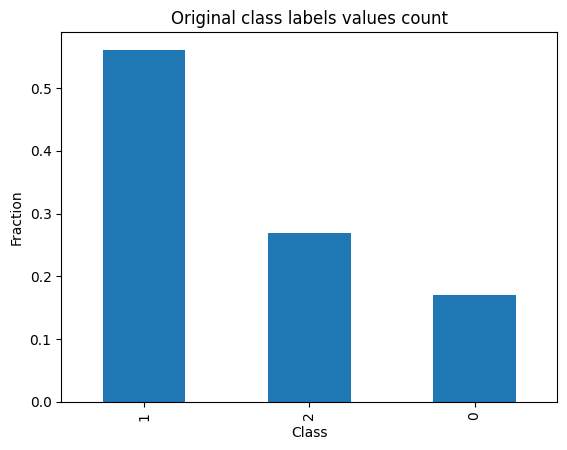

In [21]:
print("Original class labels values count")
print(0, ' - Normal')
print(1, ' - Benign')
print(2, ' - Malignant')
print(df['true_label_num'].value_counts(normalize=True))

df['true_label_num'].value_counts(normalize=True).plot(kind='bar', title='Original class labels values count',xlabel='Class', ylabel='Fraction')

plt.show()

In [22]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)

resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

model = torch.nn.Sequential(
    resnet50,
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 3)
)

# # freeze resnet layers
# for param in model[0].parameters():
#     param.requires_grad = False

# # unfreeze last layer and layer before last
# for param in model[0].fc.parameters():
#     param.requires_grad = True
# for param in model[0].layer4.parameters():
#     param.requires_grad = True

# move model to device
model = model.to(DEVICE)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0/0.1702*0.1702, 1.0/0.5608, 1.0/0.2688*1.5]).to(DEVICE))

MODEL_SAVE_DIR = 'Model_and_metrics'

optimizer = torch.optim.Adam(
            [{'params': model[0].parameters(),'lr': 9e-5},
            #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
             {'params': model[1].parameters(),'lr': 9e-4}],weight_decay=1e-2)

trainer = ClassificationTrainer(
    model=model, epochs=20, criterion=criterion, optimizer=optimizer,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    model_save_dir=MODEL_SAVE_DIR, save_best_del_rest=True, use_scheduler= True ,pbar_visible=False, displ_print=True)

In [23]:
trainer.train()

Epoch 0 Train Loss: 0.872780442237854 Train Accuracy: 0.39423078298568726, Val Loss: 0.8621527552604675, Val Accuracy: 0.5222929936305732
Epoch 1 Train Loss: 0.5592067241668701 Train Accuracy: 0.6891025900840759, Val Loss: 0.6544321179389954, Val Accuracy: 0.643312101910828
Epoch 2 Train Loss: 0.33413997292518616 Train Accuracy: 0.7692307829856873, Val Loss: 0.5325884222984314, Val Accuracy: 0.6751592356687898
Epoch 3 Train Loss: 0.20627495646476746 Train Accuracy: 0.8333333134651184, Val Loss: 0.6095978021621704, Val Accuracy: 0.6878980891719745
Epoch 4 Train Loss: 0.14546778798103333 Train Accuracy: 0.8926281929016113, Val Loss: 0.5684834718704224, Val Accuracy: 0.6878980891719745
Epoch 5 Train Loss: 0.09575086086988449 Train Accuracy: 0.9310897588729858, Val Loss: 0.6321295499801636, Val Accuracy: 0.7643312101910829
Epoch 6 Train Loss: 0.0893111601471901 Train Accuracy: 0.9695512652397156, Val Loss: 0.48748478293418884, Val Accuracy: 0.7388535031847133
Epoch 7 Train Loss: 0.07795308

In [24]:
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# SEED = 42

# torch.manual_seed(SEED)
# np.random.seed(SEED)

# resnet50 = models.resnet50(weights='ResNet50_Weights.DEFAULT')

# model = torch.nn.Sequential(
#     resnet50,
#     torch.nn.ReLU(),
#     torch.nn.Dropout(0.5),
#     torch.nn.Linear(1000, 3)
# )

# # # freeze resnet layers
# # for param in model[0].parameters():
# #     param.requires_grad = False

# # # unfreeze last layer and layer before last
# # for param in model[0].fc.parameters():
# #     param.requires_grad = True
# # for param in model[0].layer4.parameters():
# #     param.requires_grad = True

# # move model to device
# model = model.to(DEVICE)

# # Define the loss function and optimizer
# #criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0/0.1702, 1.0/0.5608, 1.0/0.2688]).to(DEVICE))
# criterion = FocalLoss(alpha=1, gamma=2, logits=True, reduce=True)

# optimizer = torch.optim.Adam(
#             [{'params': model[0].parameters(),'lr': 9e-4},
#             #  {'params': model[0].layer4.parameters(),'lr': 9e-5},
#              {'params': model[3].parameters(),'lr': 1e-3}],weight_decay=5e-1)

# trainer = ClassificationTrainer(
#     model=model, epochs=20, criterion=criterion, optimizer=optimizer,
#     train_dataloader=train_dataloader, val_dataloader=val_dataloader,
#     model_save_dir='ResNet50_try', use_scheduler= True ,pbar_visible=False, displ_print=True)

# trainer.train()

In [25]:
best_model = torch.load('Model_and_metrics/model_best.pt')

In [26]:
#print classification report
#import classification report
from sklearn.metrics import classification_report

# put model in eval mode
model.eval()
model.to(DEVICE)

# keep list of true and predicted labels
y_true = []
y_pred = []

with torch.no_grad():
    for i, (img, label) in enumerate(val_dataloader):
        # send image to device
        img = img.to(DEVICE)    # [batch_size, 3, 256, 256]
        label = label.to(DEVICE)   # [batch_size,]

        # forward pass
        output = model(img)    # [batch_size, 1]

        # y_true
        y_true.extend(label.cpu().numpy().tolist())

        # y_pred
        y_pred.extend(torch.argmax(output,dim=-1).detach().cpu().numpy())

        
print('Classification Report')
print(classification_report(y_true, y_pred))

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.62      0.71        29
           1       0.84      0.89      0.87        84
           2       0.78      0.82      0.80        44

    accuracy                           0.82       157
   macro avg       0.81      0.78      0.79       157
weighted avg       0.82      0.82      0.82       157



In [27]:
#import cv2
import cv2


In [28]:
#generate mask bounding box around the mask leave some margin
#also generate center point of the mask

def mask_bounding_box(mask,margin=5):
    '''
    mask: numpy array of the mask
    margin: margin around the bounding box
    '''
    #convert to grayscale if not
    if len(mask.shape) == 3 and mask.shape[2] == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    elif len(mask.shape) == 2:
        gray = mask
    else:
        raise ValueError("Unsupported image format")
    
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #get bounding box
    largest_contour=max(contours,key=cv2.contourArea)

    x,y,w,h=cv2.boundingRect(largest_contour)
    #where x,y are the top left corner of the bounding box

    #add margin to the bounding box
    x_min=x-margin if x-margin > 0 else 0
    y_min=y-margin if y-margin > 0 else 0
    x_max=x+w+margin if x+w+margin < mask.shape[1] else mask.shape[1]
    y_max=y+h+margin if y+h+margin < mask.shape[0] else mask.shape[0]
    #get center point
    center_x=x+w//2
    center_y=y+h//2
    return x_min,y_min,x_max,y_max,center_x,center_y



actual label: 2 predicted label: 1


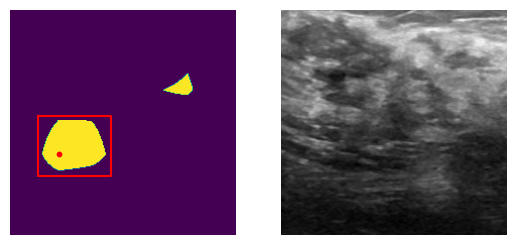

actual label: 2 predicted label: 1


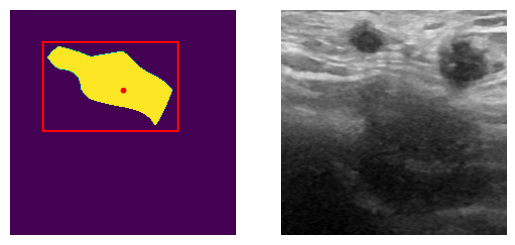

actual label: 2 predicted label: 1


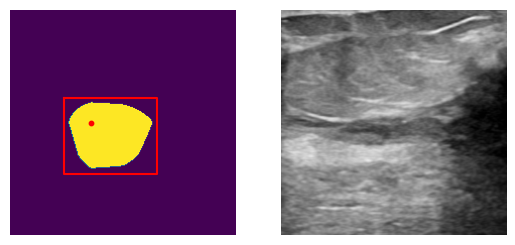

actual label: 2 predicted label: 2


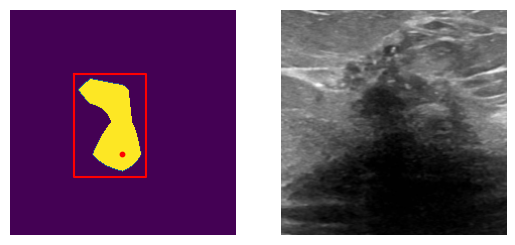

df_prompt:                         image  x_min  y_min  x_max  y_max  center_x  center_y  \
0     malignant (51)_mask.png     70    204    262    321       165       263   
1     malignant (44)_mask.png    109     82    566    310       338       196   
2    malignant (194)_mask.png    218    215    601    403       407       309   
3     malignant (97)_mask.png    163    138    351    360       257       249   
4    malignant (143)_mask.png    150    304    396    425       273       364   
..                        ...    ...    ...    ...    ...       ...       ...   
152     benign (170)_mask.png    297    125    445    284       370       204   
153     benign (231)_mask.png    235    185    415    339       325       261   
154     benign (399)_mask.png    128    114    336    242       232       177   
155      benign (25)_mask.png    333    140    584    278       457       208   
156      normal (22)_mask.png    165    117    463    262       312       188   

                

In [29]:

import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import to_pil_image

def get_prompt_from_cam(best_model, df, SEED, box_margin=5, csv_name=None,max_cam_location=False):

    df_prompt=pd.DataFrame(columns=['image','x_min','y_min','x_max','y_max','center_x','center_y','path','true_label','predicted_label'])

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # create folder PromptSAM if it does not exist
    if not os.path.exists('PromptSAM'):
        os.makedirs( 'PromptSAM')

    torch.manual_seed(SEED)
    np.random.seed(SEED)
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
        # Normalize the image using the mean and standard deviation of the ImageNet dataset
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    transforms_og = torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        #grayscale to RGB since the model was trained on RGB images
        Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),  # Convert grayscale to RGB
    ])

    dataset_og = UltrasoundDataset(df, transform=transforms, transform_og=transforms_og, return_og=True, return_img_name=True)
    dataloader_og = DataLoader(dataset_og, batch_size=1, shuffle=False)


    best_model.eval()    
    
    i=0
    with GradCAMpp(best_model) as cam_extractor:
        for img, label,og_img, img_path in dataloader_og:
            i+=1
            img = img[:1].to(DEVICE)
            label = label.to(DEVICE)
            out = best_model(img)

            activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
            #plot activation map
            #plt.imshow(activation_map[0].squeeze(0).cpu().numpy()); plt.axis('off'); plt.show() 
            
            #fig,ax = plt.subplots(1,2)
            #plt.imshow(img[0].permute(1, 2, 0).cpu().numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
            #result = overlay_mask(to_pil_image(og_img[0]), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
            #result=overlay_mask(to_pil_image(og_img[0]), to_pil_image(torch.stack(activation_map).reshape(7,7), mode='F'), alpha=0.7)
            # #Display it
            #ax[0].imshow(result); ax[0].axis('off'); 
            #ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
            
            #thresholding the activation map to get the mask
            threshold = 0.5
            activation_map= torch.stack(activation_map)
            #print('activation map shape:',activation_map.shape)
            activation_map = torch.nn.functional.interpolate(activation_map, size=(224,224), mode='bilinear', align_corners=False)
            
            #location of maximum value in the activation map
            
            x_loc,y_loc=np.where(activation_map[0].squeeze(0).cpu().numpy() == activation_map[0].squeeze(0).cpu().numpy().max())
            
            
            
            #thresholding
            mask = np.where(activation_map[0].squeeze(0).cpu().numpy() > threshold, 1, 0)
            mask=mask.astype(np.uint8)

            mask_3d = np.stack([mask]*3,axis=-1)

            x_min,y_min,x_max,y_max,center_x,center_y=mask_bounding_box(mask_3d,margin=box_margin)
            

            # Display 
            if i < 5:
                print('actual label:',label[0].item(),'predicted label:',out.argmax().item())
                fig,ax = plt.subplots(1,2)
                ax[0].imshow(mask); ax[0].axis('off');
                #show point of maximum value in the mask
                ax[0].scatter(y_loc,x_loc, c='r', s=10)
                #plot bounding box
                ax[0].plot([x_min,x_max,x_max,x_min,x_min],[y_min,y_min,y_max,y_max,y_min],'r')
                
                ax[1].imshow(og_img[0].permute(1, 2, 0).cpu().numpy()); ax[1].axis('off'); plt.show()
                
            
            #take the product of the mask and the image
            #print shape of mask and image

            cropped_img = og_img[0].permute(1, 2, 0).cpu().numpy() * mask[:,:,None]

            # Display it
            #print(cropped_img.shape)

            #plt.imshow(cropped_img); plt.axis('off'); plt.show()

            #generate mask bounding box around the mask leave some margin
            
            predicted_label = out.argmax().item()

                

            #also generate center point of the mask
            
            
            #replace center_x and center_y with the location of maximum value in the activation map
            if max_cam_location:
                center_x=y_loc[0]
                center_y=x_loc[0]
            
            
            
            #now we wamt to traslate the bounding box to the original image
            #get the original image using the path
            img_path=img_path[0]
            img_path=img_path.replace('\\','/')
            
            img_name=img_path.split('/')[-1]
            img_name=img_name.split('.')[0]
            img_name=img_name+'_mask.png'
            
            #true label
            true_label=label[0].item()
            predicted_label=out.argmax().item()
          
            # print('img_path:',img_path)
            original_img=cv2.imread(img_path)
            
            #get the original image shape
            original_img_shape=original_img.shape
            
            #get the scaling factor
            scale_x=original_img_shape[1]/224
            scale_y=original_img_shape[0]/224
            
            #scale the bounding box
            x_min=int(x_min*scale_x)
            y_min=int(y_min*scale_y)
            x_max=int(x_max*scale_x)
            y_max=int(y_max*scale_y)
            center_x=int(center_x*scale_x)
            center_y=int(center_y*scale_y)
            
            # #draw bounding box on the original image
            # bbox_point_img= original_img.copy()
    

            # #draw bounding box on the cropped image
            # bbox_point_img= cropped_img.copy()
            # cv2.rectangle(bbox_point_img,(x_min,y_min),(x_max,y_max),(0,255,0),2)
            # #draw center point
            # cv2.circle(bbox_point_img,(center_x,center_y),5,(0,0,255),-1)

            #show mask with bounding box and center point
            #plt.imshow(bbox_point_img); plt.axis('off'); plt.show()

            #get the image name
            

            
            #store the bounding box and center point in the dataframe in format image,x_min,y_min,x_max,y_max,center_x,center_y,path,true_label,predicted_label
            df_prompt.loc[len(df_prompt)] = [img_name,x_min,y_min,x_max,y_max,center_x,center_y,img_path,true_label,predicted_label]

    print('df_prompt:',df_prompt)
    #sort the dataframe by img_name
    df_prompt=df_prompt.sort_values(by='image')
    #save df_prompt to csv
    csv_path=os.path.join('PromptSAM',csv_name)
    df_prompt.to_csv(csv_path,index=False)
    print('Prompt saved to:',csv_path)
get_prompt_from_cam(model, val_df, SEED, box_margin=5, csv_name='prompt_valid.csv')


actual label: 2 predicted label: 2


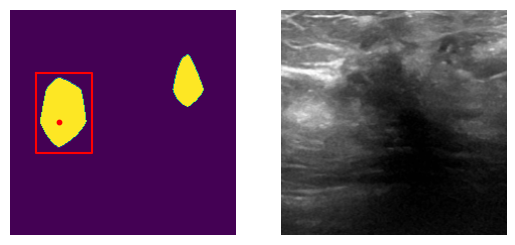

actual label: 1 predicted label: 1


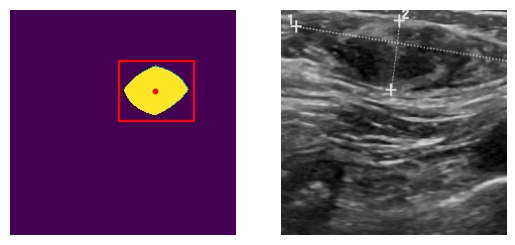

actual label: 1 predicted label: 1


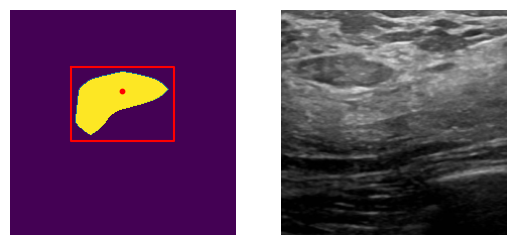

actual label: 1 predicted label: 1


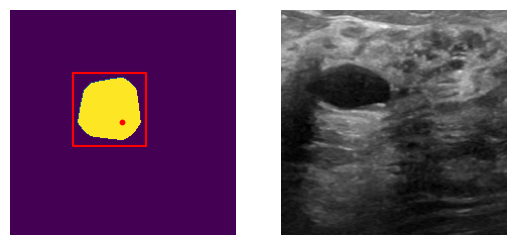

df_prompt:                        image  x_min  y_min  x_max  y_max  center_x  center_y  \
0    malignant (91)_mask.png     61    138    198    313       130       224   
1      benign (218)_mask.png    290     90    489    194       389       141   
2      benign (418)_mask.png    162    105    438    240       300       171   
3      benign (149)_mask.png    154    131    335    282       243       206   
4       benign (73)_mask.png    305    243    492    410       397       325   
..                       ...    ...    ...    ...    ...       ...       ...   
619    benign (163)_mask.png    159    151    413    285       285       218   
620    benign (195)_mask.png    188    234    364    368       276       300   
621    benign (341)_mask.png    173    205    390    341       280       273   
622     benign (97)_mask.png    272    125    507    283       388       203   
623    benign (191)_mask.png    149    105    333    217       240       161   

                            

In [30]:
get_prompt_from_cam(model, train_df, SEED, box_margin=5, csv_name='prompt_train.csv')

1. do ablation study , if regularization increase, quality of cam increase/decrease
2. try different cam and different model
3. try ensemble of cams